# Installing libraries 
* NLTK==3.4  
* yellowbrick 
* Gensim=3.6.0

In [241]:
# !pip install nltk==3.4
# !pip install yellowbrick -U
# !pip install gensim==3.6.0

/opt/anaconda3/bin/python


# Loading Libraries

In [253]:
import base64
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plotly imports
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

# # Geo Visualization

# to plot
import altair as alt
# alt.renderers.enable('mimetype')
# alt.renderers.enable('default')
alt.renderers.enable('html')

# To open url data
import urllib.request as urllib2
import json

# Other imports
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import json

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from wordcloud import WordCloud, STOPWORDS
from googletrans import Translator

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200) # to show more rows.

%matplotlib inline
%load_ext autoreload
%autoreload 2

# root to call data 
root = "../../../data/"
colombia_topo_url = 'https://raw.githubusercontent.com/OmdenaAI/omdena-colombia-career-recommender-system/main/src/data/Colombia_departamentos_municipios_poblacion-topo.json'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


References :
1. https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial
2. https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
3. https://github.com/ElizaLo/NLP-Natural-Language-Processing

In [3]:
## Get the data of the programs
# df = pd.read_json('../input/careerdb/database.json')
# df = pd.read_json('database.json')

# url
my_url="https://raw.githubusercontent.com/dsceafit/ds-squads/main/career-recommendation/frontend/src/database/database.json"

# open url
resource = urllib2.urlopen(my_url)
content =  resource.read().decode(resource.headers.get_content_charset())

# parse content to a Python dictionary
y = json.loads(content)

# use the dictonary to get a Data Frame
df = pd.DataFrame(y)

In [4]:
# show an extract of the data frame
df.tail(3)

,pregrado,Universidad,detalles,Descripcion,SNIES,Registro calificado,Nivel de formación,Tipo de formación,Título otorgado,Modalidad,Duración,Créditos,Ciudad
2935,especializacion en comunicacion y narrativas d...,institucion universitaria politecnico grancolo...,perfil del aspiranteprofesionales que esten in...,"el entorno globalizado, competitivo y cambiant...",104726,resolucion rc 10438 del 14 de julio de 2015,posgrado,especializacion,especialista en comunicacion y narrativas digi...,virtual,2 semestres,28 creditos,virtual
2936,regencia de farmacia,universidad autonoma de bucaramanga - virtual,"el regente de farmacia unab-ces, es un facilit...",el tecnologo en regencia de la unab-ces es un ...,90873,"resolucion 15164 del 02 de agosto de 2017, vig...",pregrado,tecnologica,tecnologo en regencia de farmacia unab-ces,distancia (tradicional),6 semestres,None,virtual
2937,especializacion en ordenamiento y gestion inte...,universidad santo tomas - modalidad abierta y ...,el profesional especialista en ordenamiento y ...,la especializacion en ordenamiento y gestion i...,15544,resolucion 8897,posgrado,especializacion universitaria,especialista en ordenamiento y gestion integra...,distancia (tradicional),2 semestres,26,virtual


In [5]:
df.rename(columns={'pregrado':'undergraduate',
                   'Universidad':'university',
                   'detalles':'details',
                   'Descripcion':'description',
                  'Registro calificado':'Qualified record',
                  'Nivel de formación':'Level of Education',
                  'Tipo de formación':'Type of training',
                  'Título otorgado':'Title awarded',
                  'Modalidad':'Modality',
                  'Duración':'Duration',
                  'Créditos':'Credits',
                  'Ciudad':'Town'},inplace=True)
df.head(3)

,undergraduate,university,details,description,SNIES,Qualified record,Level of Education,Type of training,Title awarded,Modality,Duration,Credits,Town
0,especializacion en gerencia de servicios de salud,universidad cooperativa de colombia - sede apa...,campos de accion,el programa de especializacion de gerencia de ...,6742,"registro 20185 del 11 de diciembre de 2015, vi...",posgrado,especializacion,especialista en gerencia de servicio de salud,presencial,2 semestres,30,apartado
1,contaduria publica,universidad cooperativa de colombia - sede apa...,objeto de estudio,las particularidades de este programa que se r...,104897,"resolucion 14090 del 07 de septiembre de 2015,...",pregrado,universitaria,contador publico,presencial,8 semestres,144,apartado
2,derecho,universidad cooperativa de colombia - sede apa...,,"el programa de derecho, estudia el sistema jur...",102434,"resolucion 9967 del 17 de junio de 2020, vigen...",pregrado,universitaria,abogado,presencial,10 semestres,158,apartado


In [6]:
def nan_check(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent_1 = data.isnull().sum()/data.isnull().count()*100
    percent_2 = (np.round(percent_1, 1)).sort_values(ascending=False)
    missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
    return missing_data

nan_check(df)

,Total,%
Credits,578,19.7
Modality,300,10.2
Title awarded,163,5.5
Duration,77,2.6
Qualified record,68,2.3
Type of training,57,1.9
SNIES,50,1.7
Level of Education,49,1.7
undergraduate,0,0.0
university,0,0.0


In [7]:
df.undergraduate.value_counts()

administracion de empresas                                                      67
contaduria publica                                                              54
derecho                                                                         50
psicologia                                                                      49
ingenieria industrial                                                           40
                                                                                ..
especializacion en derecho de la responsabilidad civil y del estado - ibague     1
diseño de modas - bogota                                                         1
redes y telecomunicaciones                                                       1
especializacion en gerencia de diseño                                            1
comunicacion social - virtual                                                    1
Name: undergraduate, Length: 1664, dtype: int64

In [8]:
# Delete words like Master, Doctorat , Especialisation, & Technology.
df1 = df[(df['undergraduate'].str.find('especializacion')==-1) &
    (df['undergraduate'].str.find('maestria')==-1) & 
    (df['undergraduate'].str.find('doctorado')==-1) & 
    (df['undergraduate'].str.find('tecnologia')==-1)]

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1127 entries, 1 to 2936
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   undergraduate       1127 non-null   object
 1   university          1127 non-null   object
 2   details             1127 non-null   object
 3   description         1127 non-null   object
 4   SNIES               1092 non-null   object
 5   Qualified record    1072 non-null   object
 6   Level of Education  1088 non-null   object
 7   Type of training    1080 non-null   object
 8   Title awarded       1028 non-null   object
 9   Modality            1015 non-null   object
 10  Duration            1083 non-null   object
 11  Credits             904 non-null    object
 12  Town                1127 non-null   object
dtypes: object(13)
memory usage: 123.3+ KB


In [9]:
df1.undergraduate.value_counts()

administracion de empresas        67
contaduria publica                54
derecho                           50
psicologia                        49
ingenieria industrial             40
                                  ..
ingenieria de petroleos            1
derecho administrativo             1
diseño industrial - bogota         1
licenciatura en artes visuales     1
biologia ambiental                 1
Name: undergraduate, Length: 375, dtype: int64

In [10]:
def replace_str(x):
    if (str(x).find('administracion') != -1) or (str(x).find('contaduria') != -1) \
    or (str(x).find('economia') != -1) or (str(x).find('negocios') != -1) \
    or (str(x).find('mercadeo') != -1) or (str(x).find('finanzas') != -1) \
    or (str(x).find('publicidad') != -1) or (str(x).find('comercio') != -1):
        return 'BUSINESS'
    elif str(x).find('ingenieria') != -1:
        return 'ENGINEERING'
    elif (str(x).find('derecho') != -1)   or (str(x).find('psico') != -1) \
    or (str(x).find('comunicacion') != -1) or (str(x).find('social') != -1) \
    or (str(x).find('pedagogia') != -1) or (str(x).find('filosofia') != -1) \
    or (str(x).find('educacion infantil') != -1) or (str(x).find('teologia') != -1) \
    or (str(x).find('antropologia') != -1) or (str(x).find('ciencia politica') != -1) \
    or (str(x).find('historia') != -1) or (str(x).find('sociologia') != -1) \
    or (str(x).find('literatura') != -1) or (str(x).find('ciencias politicas') != -1) \
    or (str(x).find('relaciones internacionales') != -1):
        return 'HUMANITIES AND SOCIAL SCIENCE'
    elif (str(x).find('medicina') != -1) or (str(x).find('enfermeria') != -1) \
    or (str(x).find('odontologia') != -1) or (str(x).find('salud en el trabajo') != -1) \
    or (str(x).find('quirurgica') != -1) :
        return 'HEALTH & MEDICINE'
    elif (str(x).find('nutricion') != -1) :
        return 'NUTRITION AND DIETETICS'
    #elif (str(x).find('nutricion') != -1) :
    #    return 'NUTRITION AND DIETETICS'
    elif (str(x).find('educacion fisica') != -1) or (str(x).find('fisioterapia') != -1):
        return 'SPORTS AND PHYSICAL TRAIN'
    elif (str(x).find('artes plasticas') != -1) or (str(x).find('artes visuales') != -1) \
    or (str(x).find('artes audiovisuales') != -1) or (str(x).find('audiovisuales') != -1) \
    or (str(x).find('produccion cultural') != -1) :
        return 'PLASTIC ARTS, VISUAL ARTS'
    elif (str(x).find('arquitectura') != -1) or (str(x).find('music') != -1) \
    or (str(x).find('diseño') != -1) or (str(x).find('artes') != -1) \
    or (str(x).find('fotografia') != -1):
        return 'ARTS AND DESIGN'
    elif (str(x).find('matematicas') != -1) or (str(x).find('fisica') != -1) \
    or (str(x).find('estadistica') != -1) or (str(x).find('biologia') != -1) \
    or (str(x).find('quimica') != -1) :
        return 'MATH AND PHYSICAL SCIENCES'
    elif (str(x).find('ciencias naturales') != -1) or (str(x).find('biologia') != -1) \
    or (str(x).find('conservacion') != -1) or (str(x).find('medio ambiente') != -1):
        return 'BIOLOGICAL SCIENCE'
    else:
        return 'OTHER'

In [11]:
df1['final_cat'] = df1['undergraduate'].apply(replace_str)
df1['final_cat'].value_counts(normalize = True)

BUSINESS                         0.251996
HUMANITIES AND SOCIAL SCIENCE    0.240461
ENGINEERING                      0.228926
OTHER                            0.100266
HEALTH & MEDICINE                0.062999
ARTS AND DESIGN                  0.048802
MATH AND PHYSICAL SCIENCES       0.041704
SPORTS AND PHYSICAL TRAIN        0.010648
PLASTIC ARTS, VISUAL ARTS        0.007098
BIOLOGICAL SCIENCE               0.005324
NUTRITION AND DIETETICS          0.001775
Name: final_cat, dtype: float64

In [12]:
# Droping OTHER Undergraduate
df1 = df1[df1['final_cat'] != 'OTHER']
# Dropping void Description
df1= df1[df1['description']!='']
# replacing big space
df1['description'] = df1['description'].str.strip('').replace('  ', ' ')

In [13]:
df1.head(3)

,undergraduate,university,details,description,SNIES,Qualified record,Level of Education,Type of training,Title awarded,Modality,Duration,Credits,Town,final_cat
1,contaduria publica,universidad cooperativa de colombia - sede apa...,objeto de estudio,las particularidades de este programa que se r...,104897,"resolucion 14090 del 07 de septiembre de 2015,...",pregrado,universitaria,contador publico,presencial,8 semestres,144,apartado,BUSINESS
2,derecho,universidad cooperativa de colombia - sede apa...,,"el programa de derecho, estudia el sistema jur...",102434,"resolucion 9967 del 17 de junio de 2020, vigen...",pregrado,universitaria,abogado,presencial,10 semestres,158,apartado,HUMANITIES AND SOCIAL SCIENCE
3,psicologia,universidad cooperativa de colombia - sede arauca,,"en la universidad cooperativa de colombia, el ...",54920,"resolucion 16951 del 22 de agosto de 2016​, vi...",pregrado,profesional universitaria,psicologo,presencial,8 semestres,147,arauca,HUMANITIES AND SOCIAL SCIENCE


In [14]:
data = [go.Bar(
            x = df1.final_cat.unique(),
            y = df1.final_cat.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = df1.final_cat.value_counts().values
                        ),
            text='Text entries attributed to Final Category'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [15]:
data = [go.Bar(
            x = df1.undergraduate.unique(),
            y = df1.undergraduate.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = df1.undergraduate.value_counts().values
                        ),
            text='Text entries attributed to undergraduate Category'
    )]

layout = go.Layout(
    title='Undergraduate variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [16]:
all_words = df1['undergraduate'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the Undergraduate'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [17]:
all_words = df1['description'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the Description'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [18]:
all_words = df1['university'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the University'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

**list of stopwords to add to the spanish stopwords**

In [153]:
stopwords_new = [
                 # spanish
                 'universidad','programa', 'formacion','desarrollo','profesionales',
                 'colombia', 'estudiante', 'quindio', 'cooperativa', 'santo', 'tomas',
                 'sergio','arboleda','pontificia','bolivariana','acreditacion','resolucion', 
                 'años','ministerio','alta','calidad','nacional','educacion','vigencia',
                 'acreditado', 'más', 'mas', 'unir', 'paises', 'pais', 'espa', 'no', 'os', 
                 'a','d',  'et',  'dame',  'il', 'diferentes',
                  # english
                 'university', 'program', 'formation', 'differents', 'country'
                ]

# NLTK 

* Tokenization
* Stopwords removal
* Bigram Construction

In [103]:
%%time

# Translate 'despcription' to English

desc_eng = []
translator = Translator()
for i in range(0, len(df1)):
    translation = translator.translate(df1['description'][i], dest='en')
    desc_eng.append(translation.text)
    
df1['description_eng'] = desc_eng

CPU times: user 6.53 s, sys: 630 ms, total: 7.16 s
Wall time: 15min 39s


In [105]:
df1.head(2)

,undergraduate,university,details,description,SNIES,Qualified record,Level of Education,Type of training,Title awarded,Modality,Duration,Credits,Town,final_cat,token,token_no_stopwords,bigram,description_eng
0,contaduria publica,universidad cooperativa de colombia - sede apa...,objeto de estudio,las particularidades de este programa que se r...,104897,"resolucion 14090 del 07 de septiembre de 2015,...",pregrado,universitaria,contador publico,presencial,8 semestres,144,apartado,BUSINESS,"[las, particularidades, de, este, programa, qu...","[particularidades, relaciona, economia, solida...","[(particularidades, relaciona), (relaciona, ec...",The particularities of this program that relat...
1,derecho,universidad cooperativa de colombia - sede apa...,,"el programa de derecho, estudia el sistema jur...",102434,"resolucion 9967 del 17 de junio de 2020, vigen...",pregrado,universitaria,abogado,presencial,10 semestres,158,apartado,HUMANITIES AND SOCIAL SCIENCE,"[el, programa, de, derecho, ,, estudia, el, si...","[derecho, estudia, sistema, juridico, sera, ob...","[(derecho, estudia), (estudia, sistema), (sist...","The program of law, studies the legal system, ..."


In [154]:
nltk.download('punkt')
nltk.download('stopwords')

spanish_stopwords = stopwords.words('spanish')
spanish_stopwords.extend(stopwords_new)

english_stopwords = stopwords.words('english')
english_stopwords.extend(stopwords_new)

## spanish
# def tokenize(sentence):
#     return [token for token in nltk.word_tokenize(sentence)]
# def remove_stopwords(sentence):
#     return [token for token in nltk.word_tokenize(sentence) if (token.lower() not in spanish_stopwords) and (token.lower() !=' ') and (token not in string.punctuation)]

# english
def tokenize(sentence):
    return [token for token in nltk.word_tokenize(sentence)]
def remove_stopwords(sentence):
    return [token for token in nltk.word_tokenize(sentence) if (token.lower() not in english_stopwords) and (token.lower() !=' ') and (token not in string.punctuation)]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vcuspinera/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vcuspinera/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Create the cleaner function to clean the spanish text, remove non alpha numeric characters, remove duplicate, remove spanish accutes, remove digits

In [155]:
%%time

## spanish
# df1['token'] = df1['description'].apply(lambda x: tokenize(x))
# df1['token_no_stopwords'] = df1['description'].apply(lambda x: remove_stopwords(x))
# df1['bigram'] = df1['token_no_stopwords'].apply(lambda x: list(ngrams(x, 2)))

## english
df1['token'] = df1['description_eng'].apply(lambda x: tokenize(x))
df1['token_no_stopwords'] = df1['description_eng'].apply(lambda x: remove_stopwords(x))
df1['bigram'] = df1['token_no_stopwords'].apply(lambda x: list(ngrams(x, 2)))

CPU times: user 776 ms, sys: 3.43 ms, total: 779 ms
Wall time: 781 ms


In [156]:
df1.tail(3)

,undergraduate,university,details,description,SNIES,Qualified record,Level of Education,Type of training,Title awarded,Modality,Duration,Credits,Town,final_cat,token,token_no_stopwords,bigram,description_eng
997,economia,universidad ean - virtual,la universidad ean ofrece este programa con lo...,conviertete en un profesional con sello empren...,102065,"resolucion 14937 del 41232, vigencia 7 años",pregrado,universitaria,economista,virtual,9 semestres,144,virtual,BUSINESS,"[Become, a, professional, with, an, entreprene...","[Become, professional, entrepreneurial, seal, ...","[(Become, professional), (professional, entrep...",Become a professional with an entrepreneurial ...
998,mercadeo,universidad ean - virtual,competencias:,conquistaras los diferentes mercados gracias a...,53442,"res. nº. 11684 del mineducacion - 22/07/14, v...",pregrado,profesional,profesional en mercadeo,None,8 semestres,144,virtual,BUSINESS,"[Conquer, the, different, markets, thanks, to,...","[Conquer, different, markets, thanks, skills, ...","[(Conquer, different), (different, markets), (...",Conquer the different markets thanks to the sk...
999,seguridad y salud en el trabajo,universidad autonoma de bucaramanga - virtual,el estudiante del programa seguridad y salud e...,"el programa seguridad y salud en el trabajo, m...",108592,"resolucion 14466 del 13 de diciembre de 2019, ...",pregrado,profesional,profesional en seguridad y salud en el trabajo,virtual,9 semestre,None,virtual,HEALTH & MEDICINE,"[The, Program, Safety, and, Health, at, Work, ...","[Safety, Health, Work, Virtual, Methodology, a...","[(Safety, Health), (Health, Work), (Work, Virt...","The Program Safety and Health at Work, Virtual..."


In [157]:
df1['token_no_stopwords'][1]

['law',
 'studies',
 'legal',
 'system',
 'subject',
 'discussion',
 'analysis',
 'interpretation',
 'criticism',
 'argument',
 'effective',
 'application',
 'different',
 'contexts',
 'favor',
 'fair',
 'social',
 'order']

# Topic Modeling 

* TF-IDF
* KMeans

In [158]:
df1.reset_index(drop=True, inplace=True)

## TF-IDF

In [159]:
## spanish
# vectorizer = TfidfVectorizer(stop_words=spanish_stopwords, min_df=0.005)
# X = vectorizer.fit_transform(df1['description'])

# english
vectorizer = TfidfVectorizer(stop_words=english_stopwords, min_df=0.005)
X = vectorizer.fit_transform(df1['description_eng'])


### Visualizing more important terms 

* Top 30

In [160]:
N_WORDS = 30
mean_data_tfidf = np.array( X.mean( axis=0 ) ).flatten()
vocabulary = vectorizer.get_feature_names()
words_id = np.flip( mean_data_tfidf.argsort()[-N_WORDS:] )

word_val_data = [ (vocabulary[id], mean_data_tfidf[id]) for id in words_id ]
word_val_data = pd.DataFrame(word_val_data, columns=['words','values'])

<Figure size 1080x720 with 0 Axes>

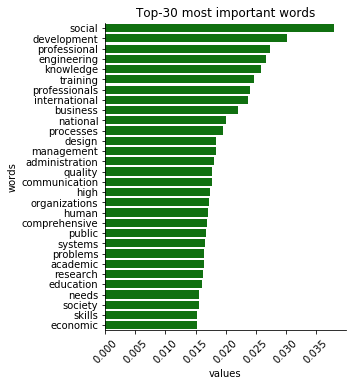

In [161]:
plt.figure(figsize=(15,10))
g = sns.catplot(data=word_val_data, color='green',
                 x='values', y='words', kind='bar' )
g.ax.tick_params(axis='x', rotation=45)
g.ax.set_title( f"Top-{N_WORDS} most important words" )
plt.show()

# KMeans

## Selecting number of clusters
* Silhouette Score

In [162]:
from sklearn.metrics import silhouette_score, silhouette_samples


In [163]:
%%time
cluster_sizes = range(2, 11+1)
kmeans_models = [ KMeans(i, n_init=10, random_state=2140) for i in cluster_sizes ]
cluster_score = []

for kmeans in kmeans_models:
    y = kmeans.fit_predict(X)
    score = silhouette_score(X, y)
    cluster_score.append( ( kmeans.n_clusters, score) )

cluster_score=np.array(cluster_score)

CPU times: user 21.1 s, sys: 2.27 s, total: 23.3 s
Wall time: 2.35 s


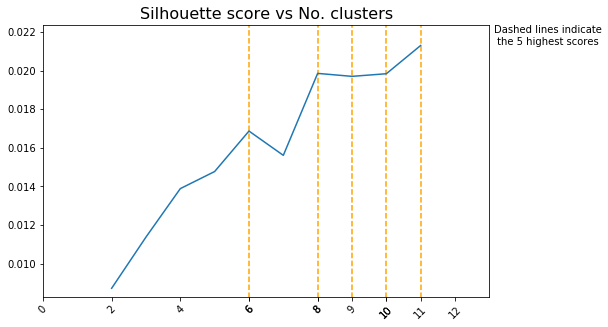

CPU times: user 979 ms, sys: 107 ms, total: 1.09 s
Wall time: 173 ms


In [164]:
%%time
scores = cluster_score[:, 1]
clusters = cluster_score[:, 0]
max_score_clusters = []

fig, ax = plt.subplots( figsize=(8,5) )
ax = sns.lineplot( x=clusters, y=scores, ax=ax )
ax.set_title("Silhouette score vs No. clusters", fontsize=16)

for i in np.argsort( scores )[-5:]:
    ax.vlines(clusters[i], 0, 1, linestyles='--', colors='orange')
    max_score_clusters.append( clusters[i] )

ax.text(1.01, 1, f"Dashed lines indicate\n the {len(max_score_clusters)} highest scores",
        transform=ax.transAxes, ha='left', va='top')

xticks = ax.get_xticks().astype(int)
xticks = np.append(xticks, max_score_clusters)
ax.set_xticks( xticks )
ax.tick_params(axis='x', rotation=45)

ax.set_ylim( [ 0.95*min(scores), 1.05*max(scores) ] )
ax.set_xlim( [ 0, max(clusters)+2 ] )

plt.show()

## Depending on the Silhouette Score above will chose K=10

In [165]:
n_clusters=10
kmeans_model = KMeans(n_clusters, n_init=20, random_state=2140)
y = kmeans_model.fit_predict(X)

## Results visualization of Silhouette Score

### Silhouette samples

In [166]:
sample_scores = silhouette_samples( X, y )
sample_scores_df =  pd.DataFrame( data = {'Cluster':y, 'Silhouette':sample_scores} )
sample_scores_df = sample_scores_df.reset_index()
sample_scores_df=sample_scores_df.sort_values('Silhouette', ascending=False)
sample_scores_df

,index,Cluster,Silhouette
153,153,8,0.373620
934,934,8,0.347479
290,290,2,0.344991
31,31,2,0.344991
750,750,2,0.344991
...,...,...,...
494,494,9,-0.040226
408,408,9,-0.042619
283,283,9,-0.044102
680,680,4,-0.045544


In [167]:
sample_scores_df.Cluster.unique()

array([8, 2, 5, 1, 0, 6, 3, 4, 7, 9], dtype=int32)

In [168]:
def plot_silhouette_samples(X, pred_labels):
    n_clusters = len(np.unique(pred_labels))

    fig, (ax) = plt.subplots(1, 1, figsize=(8,8))
  
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])

    silhouette_avg = silhouette_score(X, pred_labels)
    sample_silhouette_values = silhouette_samples(X, pred_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[pred_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
  
        ax.fill_betweenx(np.arange(y_lower, y_upper), 
                     0, ith_cluster_silhouette_values )
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i),
            ha='center', va='center', fontsize=12,
            bbox={'boxstyle':'square',
                  'facecolor':'white'})
        y_lower = y_upper + 10
  
    ax.set_title(f"The silhouette score plot for the {n_clusters} clusters.\n",fontsize=20)
    ax.set_xlabel("Silhouette coefficient values",fontsize=18)
    ax.set_ylabel("Cluster",fontsize=18)
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    fig.savefig("silhouette.png")
    plt.show()

    return ax

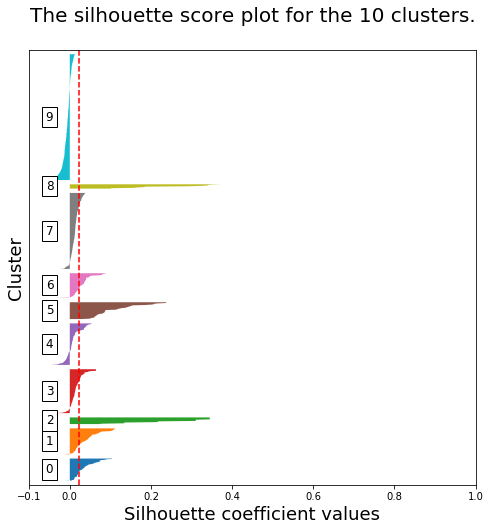

In [169]:
plot_silhouette_samples(X, y)

## Most Important top 5 Words in each cluster

In [170]:
def most_important_words(data_tfidf, y, topn=20):
    n_clusters = len(np.unique(y))
    result = []
    for i in range(n_clusters):
        ith_cluter_word_sum = np.mean(data_tfidf[np.argwhere(y==i).flatten()], axis=0)
    
        word_ids = np.array( np.argsort( ith_cluter_word_sum )[0, -topn:] )
        word_ids = word_ids.reshape( -1 )
        result = result + [ (i, id, ith_cluter_word_sum[0, id] ) for id in word_ids ]

    return result

In [171]:
word_cluster_df = pd.DataFrame( most_important_words( X, y, topn=20 ), columns=["Cluster", "WordId", "Score"] )
word_cluster_df["Word"] = word_cluster_df["WordId"].apply( lambda id: vectorizer.get_feature_names()[id] )
word_cluster_df = word_cluster_df.sort_values( "Score", ascending=False )
word_cluster_df.head()

,Cluster,WordId,Score,Word
59,2,930,0.272349,solidarity
19,0,180,0.234730,communication
119,5,16,0.213956,accreditation
118,5,862,0.212324,resolution
179,8,228,0.195762,contexts


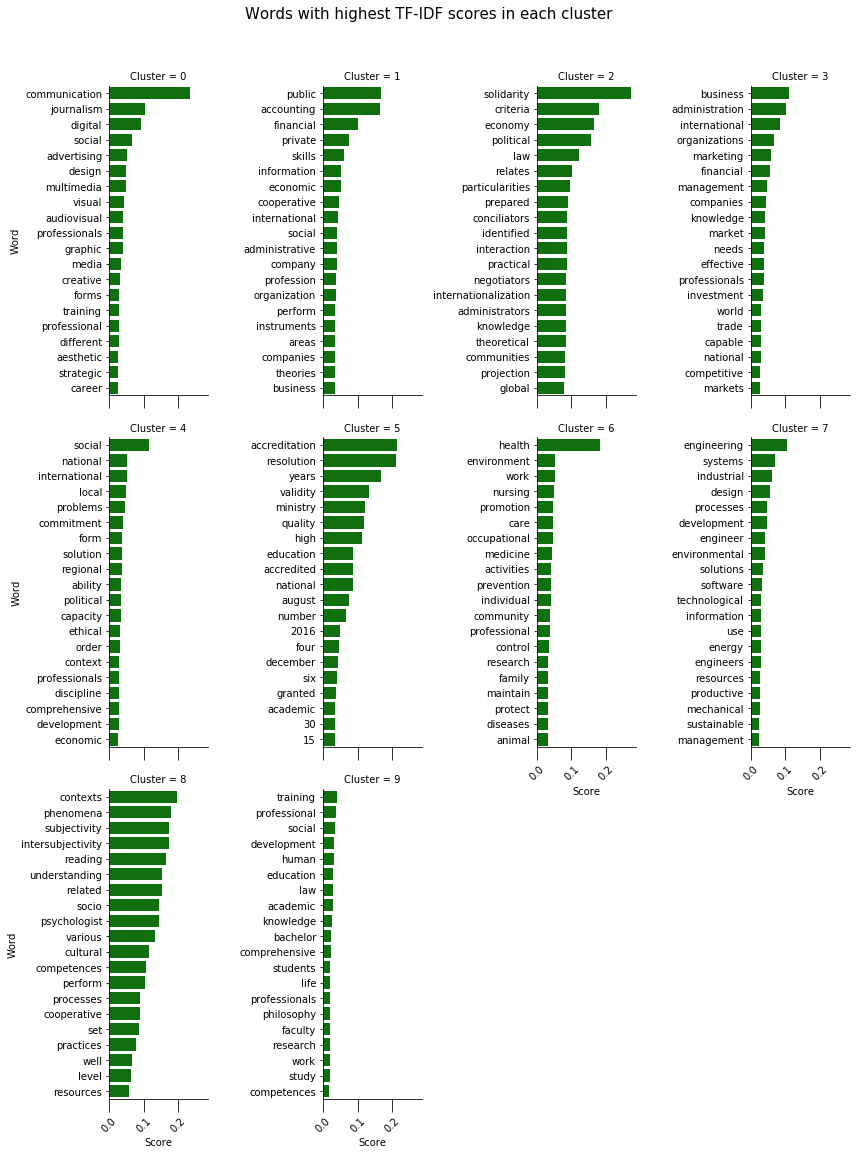

In [172]:
g = sns.catplot(x="Score", y="Word", col="Cluster", data=word_cluster_df, 
                sharey=False, col_wrap=4, kind="bar",
                color = 'green', aspect=.6)
[ ax.tick_params(axis='x', rotation=45, size=13) for ax in g.axes.flatten() ]
g.fig.suptitle( "Words with highest TF-IDF scores in each cluster", y = 1.05, fontsize=15 )
g.fig.savefig("kmeans_clusters_top20WordsperEach.png".format(i))
plt.show()

In [173]:
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())
final_df = tf_idf
print("{} rows".format(final_df.shape[0]))
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0)

1000 rows


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
relates,0.302953,0.0,0.0,0.0,0.0,0.0,0.302953,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
particularities,0.286403,0.0,0.0,0.0,0.0,0.0,0.286403,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
prepared,0.266930,0.0,0.0,0.0,0.0,0.0,0.266930,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
interaction,0.257999,0.0,0.0,0.0,0.0,0.0,0.257999,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
internationalization,0.252797,0.0,0.0,0.0,0.0,0.0,0.252797,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Most Important top 20 Words in each cluster

In [174]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    fig = plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        fig.savefig("kmeans_cluster{}_topWordsFIG.png".format(i))
        plt.show()
    


In [175]:
%%time
final_df_array = final_df.to_numpy()
prediction = kmeans_model.predict(final_df)


CPU times: user 20.3 ms, sys: 3.95 ms, total: 24.2 ms
Wall time: 15.7 ms


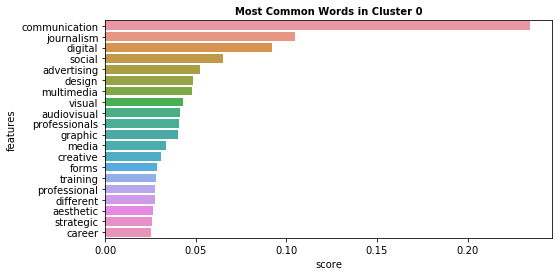

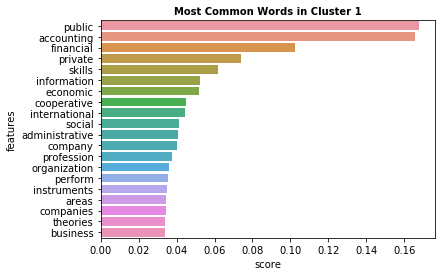

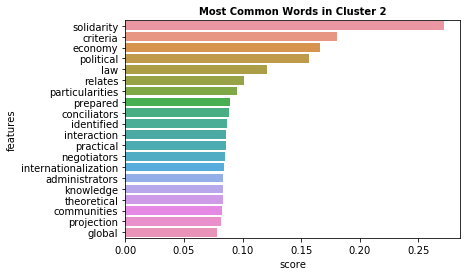

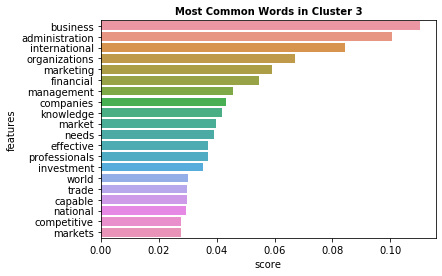

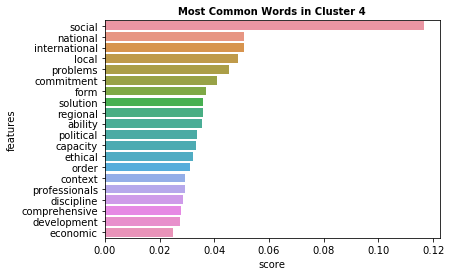

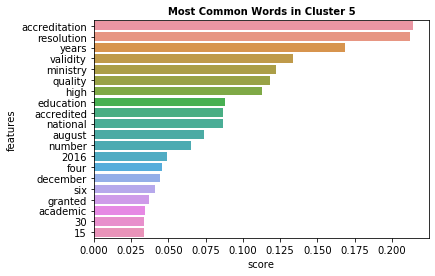

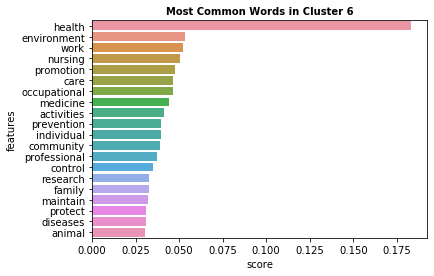

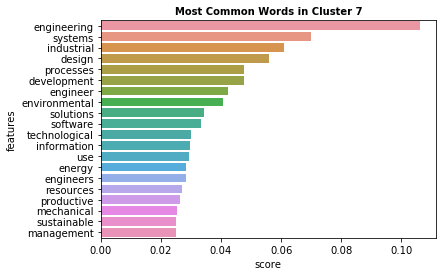

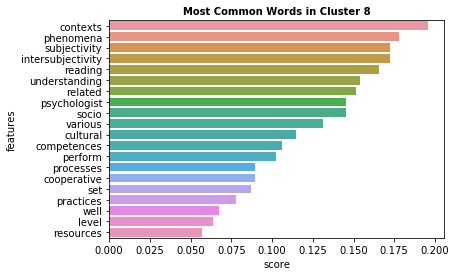

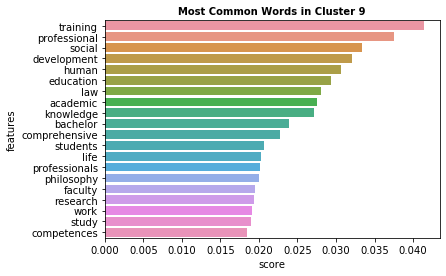

In [176]:
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, n_feats)

## Word Cloud for Each Cluster

### Transforms a centroids dataframe into a dictionary to be used on a WordCloud.

In [177]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        fig = plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        fig.savefig("WordClouds_clusters{}_topWors.png".format(i))
        plt.show()

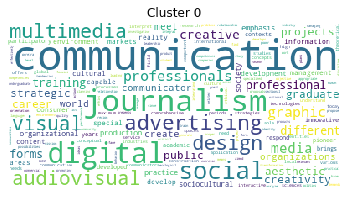

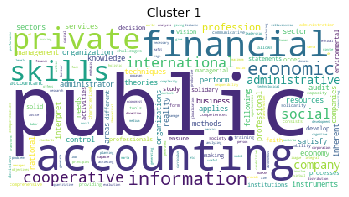

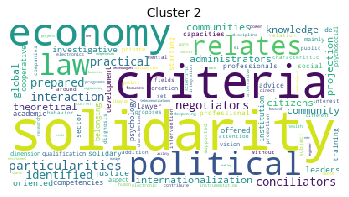

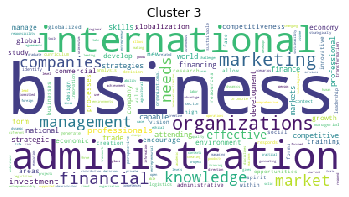

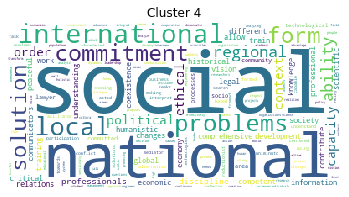

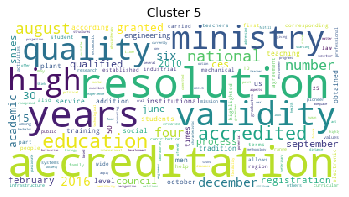

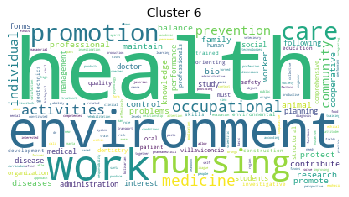

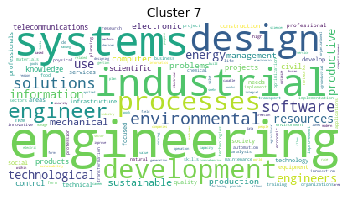

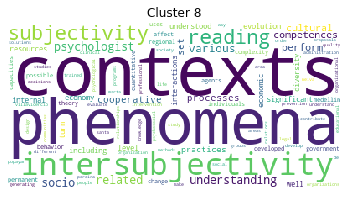

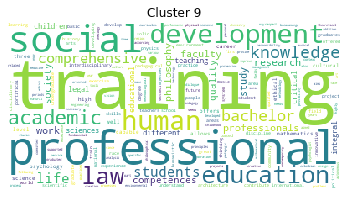

In [179]:
centroids = pd.DataFrame(kmeans_model.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)


In [218]:
cluster_names = {
    'Cluster 0':'communication',
    'Cluster 1':'finances',
    'Cluster 2':'social science',
    'Cluster 3':'business',
    'Cluster 4':'social studies at geographical level',
    'Cluster 5':'education',
    'Cluster 6':'health science',
    'Cluster 7':'engineering and technology',
    'Cluster 8':'arts',
    'Cluster 9':'training'
}

print("\n⚠️ Caution: The clusters can change in order and general meaning\n \
            when varing any variable (por example, stop words).\n")

df_names = pd.DataFrame([cluster_names]).T.reset_index().rename(columns={
    'index':'Cluster', 0:"Naming the cluster"})

df_names


⚠️ Caution: The clusters can change in order and general meaning
             when varing any variable (por example, stop words).



,Cluster,Naming the cluster
0,Cluster 0,communication
1,Cluster 1,finances
2,Cluster 2,social science
3,Cluster 3,business
4,Cluster 4,social studies at geographical level
5,Cluster 5,education
6,Cluster 6,health science
7,Cluster 7,engineering and technology
8,Cluster 8,arts
9,Cluster 9,training


In [219]:
## Save dataframes
# final_df.to_csv("final_df.csv")
# centroids.to_csv("centroids.csv")
# df_clustered.to_csv("clustered_data_withCentroids.csv")

In [220]:
df_clustered = df1.copy()

In [221]:
# Assigning the cluster labels to each country
labels = kmeans_model.labels_ 
df_clustered['Cluster'] = labels
df_clustered.tail(3)

,undergraduate,university,details,description,SNIES,Qualified record,Level of Education,Type of training,Title awarded,Modality,Duration,Credits,Town,final_cat,token,token_no_stopwords,bigram,description_eng,Cluster
997,economia,universidad ean - virtual,la universidad ean ofrece este programa con lo...,conviertete en un profesional con sello empren...,102065,"resolucion 14937 del 41232, vigencia 7 años",pregrado,universitaria,economista,virtual,9 semestres,144,virtual,BUSINESS,"[Become, a, professional, with, an, entreprene...","[Become, professional, entrepreneurial, seal, ...","[(Become, professional), (professional, entrep...",Become a professional with an entrepreneurial ...,9
998,mercadeo,universidad ean - virtual,competencias:,conquistaras los diferentes mercados gracias a...,53442,"res. nº. 11684 del mineducacion - 22/07/14, v...",pregrado,profesional,profesional en mercadeo,None,8 semestres,144,virtual,BUSINESS,"[Conquer, the, different, markets, thanks, to,...","[Conquer, different, markets, thanks, skills, ...","[(Conquer, different), (different, markets), (...",Conquer the different markets thanks to the sk...,3
999,seguridad y salud en el trabajo,universidad autonoma de bucaramanga - virtual,el estudiante del programa seguridad y salud e...,"el programa seguridad y salud en el trabajo, m...",108592,"resolucion 14466 del 13 de diciembre de 2019, ...",pregrado,profesional,profesional en seguridad y salud en el trabajo,virtual,9 semestre,None,virtual,HEALTH & MEDICINE,"[The, Program, Safety, and, Health, at, Work, ...","[Safety, Health, Work, Virtual, Methodology, a...","[(Safety, Health), (Health, Work), (Work, Virt...","The Program Safety and Health at Work, Virtual...",6


In [222]:
df_clustered['Silhouette_score'] = sample_scores_df['Silhouette']
df_clustered.tail(3)

,undergraduate,university,details,description,SNIES,Qualified record,Level of Education,Type of training,Title awarded,Modality,Duration,Credits,Town,final_cat,token,token_no_stopwords,bigram,description_eng,Cluster,Silhouette_score
997,economia,universidad ean - virtual,la universidad ean ofrece este programa con lo...,conviertete en un profesional con sello empren...,102065,"resolucion 14937 del 41232, vigencia 7 años",pregrado,universitaria,economista,virtual,9 semestres,144,virtual,BUSINESS,"[Become, a, professional, with, an, entreprene...","[Become, professional, entrepreneurial, seal, ...","[(Become, professional), (professional, entrep...",Become a professional with an entrepreneurial ...,9,-0.012653
998,mercadeo,universidad ean - virtual,competencias:,conquistaras los diferentes mercados gracias a...,53442,"res. nº. 11684 del mineducacion - 22/07/14, v...",pregrado,profesional,profesional en mercadeo,None,8 semestres,144,virtual,BUSINESS,"[Conquer, the, different, markets, thanks, to,...","[Conquer, different, markets, thanks, skills, ...","[(Conquer, different), (different, markets), (...",Conquer the different markets thanks to the sk...,3,0.011826
999,seguridad y salud en el trabajo,universidad autonoma de bucaramanga - virtual,el estudiante del programa seguridad y salud e...,"el programa seguridad y salud en el trabajo, m...",108592,"resolucion 14466 del 13 de diciembre de 2019, ...",pregrado,profesional,profesional en seguridad y salud en el trabajo,virtual,9 semestre,None,virtual,HEALTH & MEDICINE,"[The, Program, Safety, and, Health, at, Work, ...","[Safety, Health, Work, Virtual, Methodology, a...","[(Safety, Health), (Health, Work), (Work, Virt...","The Program Safety and Health at Work, Virtual...",6,0.048532


In [223]:
from bokeh.plotting import figure, show, output_notebook, output_file, save
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Category10
import umap
from sklearn.decomposition import PCA

In [ ]:
#2D view of clusters and data with U-Map
output_notebook()

In [ ]:
pca = PCA( 0.95, random_state=2140)
data_pca = pca.fit_transform(X.todense())

In [ ]:
umap_red = umap.UMAP(n_neighbors=12, metric='correlation', 
                     random_state=214)
data_2d = umap_red.fit_transform( data_pca )

In [ ]:
data_2d

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
df1.description = df1['description'].astype(str) 

In [ ]:
data_2d_df.head()

In [ ]:
data_2d_df = pd.DataFrame( data={"x":data_2d[:, 0], 
                                 "y":data_2d[:, 1], 
                                 "Cluster":y,
                                 "Silhouette":sample_scores } )

c_pallete = list(Category10[10])
c_pallete[7], c_pallete[0] = c_pallete[0], c_pallete[7]

data_2d_df['colors'] = [ c_pallete[i] for i in data_2d_df['Cluster'] ]
data_2d_df['description'] = df1['description']

In [ ]:
data_2d_df = data_2d_df.fillna(' ')

In [ ]:
#Limiting the text's size
data_2d_df['description'] = data_2d_df['description'].str.slice(0,5)

data_2d_df, _,_,_ = train_test_split(data_2d_df, data_2d_df, train_size=800, stratify=data_2d_df['Cluster'])

data_2d_cdf = ColumnDataSource(data_2d_df)

In [ ]:
fig = figure(
    title='UMAP 2D projection of the points and clusters',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset', 'save')
)

fig.add_tools(HoverTool(tooltips="""
                                      <div>
                                        <span style='font-size: 10px; color: @colors'>@ementa</span>
                                        <span style='font-size: 10px'>cluster - </span>
                                        <span style='font-size: 10px'>@Cluster ;</span>
                                        <span style='font-size: 10px'>index - </span>
                                        <span style='font-size: 10px'>$index ;</span>
                                        <span style='font-size: 10px'>silhouette: </span>
                                        <span style='font-size: 10px'>@Silhouette</span>
                                      </div>
                                 """)
              )

fig.circle('x','y', source=data_2d_cdf, color='colors', 
           legend_group="Cluster",
           line_alpha=0.6, fill_alpha=0.6, size=2)

show(fig)
save(fig, "UMAP2D.html")

# Geo Visualization

In [224]:
# Towns
print(df_clustered.Town.unique())

['apartado' 'arauca' 'armenia' 'barrancabermeja' 'barranquilla' 'bello'
 'manizales' 'ibague' 'girardota' 'el espinal' 'cundinamarca' 'cartago'
 'cartagena' 'cali' 'cucuta' 'bucaramanga' 'bogota' 'medellin' 'monteria'
 'neiva' 'palmira' 'pasto' 'pereira' 'popayan' 'quibdo' 'santa marta'
 'tolima' 'tunja' 'valle' 'villavicencio' 'virtual']


### Polygons data

In [225]:
# States Polygons
states = alt.topo_feature(colombia_topo_url, feature='MGN_AMN_DPTOS')

# Municipalitys Polygons
municipalities = alt.topo_feature(colombia_topo_url, feature='MGN_AMN_MPIOS')

### Clusters by Town

In [226]:
town_DANE_code = {
    'apartado':'05045', 'arauca':'81001', 'armenia':'63001', 'barrancabermeja':'68081',
    'barranquilla':'08001', 'bello':'05088', 'manizales':'17001', 'ibague':'73001', 
    'girardota':'05308', 'el espinal':'73268', 'cundinamarca':'25754',
    'cartago':'76147', 'cartagena':'13001', 'cali':'76001', 'cucuta':'54001',
    'bucaramanga':'68001', 'bogota':'11001', 'medellin':'05001', 'monteria':'23001' ,
    'neiva':'41001' , 'palmira':'76520', 'pasto':'52001' , 'pereira':'66001', 
    'popayan':'19001', 'quibdo':'27001', 'santa marta':'47001', 'tolima':'73001', 
    'tunja':'15001', 'valle':'76001', 'villavicencio':'50001', 'virtual':'online'
}

# reference: Municipalities IDs at http://www.statoids.com/yco.html
# notes: 'cundinamarca' is a Department, so I use the code of 'soacha' which is the  
#       municipality more piupulated of the state; 'tolima' is also a Department, so
#       I use the code of it's capital 'ibague'; 'valle' I supose that makes reference 
#       to 'Valle del Cauca' which is also a Department, so I use the code of it's
#       capital 'cali'; virtual' means 'online'.

# add DANE codes to dataframe for Municipalities
df_clustered['DANE_code'] = df_clustered['Town'].replace(town_DANE_code)

df_clustered.head()

,undergraduate,university,details,description,SNIES,Qualified record,Level of Education,Type of training,Title awarded,Modality,...,Credits,Town,final_cat,token,token_no_stopwords,bigram,description_eng,Cluster,Silhouette_score,DANE_code
0,contaduria publica,universidad cooperativa de colombia - sede apa...,objeto de estudio,las particularidades de este programa que se r...,104897,"resolucion 14090 del 07 de septiembre de 2015,...",pregrado,universitaria,contador publico,presencial,...,144,apartado,BUSINESS,"[The, particularities, of, this, program, that...","[particularities, relates, solidarity, economy...","[(particularities, relates), (relates, solidar...",The particularities of this program that relat...,2,0.344991,05045
1,derecho,universidad cooperativa de colombia - sede apa...,,"el programa de derecho, estudia el sistema jur...",102434,"resolucion 9967 del 17 de junio de 2020, vigen...",pregrado,universitaria,abogado,presencial,...,158,apartado,HUMANITIES AND SOCIAL SCIENCE,"[The, program, of, law, ,, studies, the, legal...","[law, studies, legal, system, subject, discuss...","[(law, studies), (studies, legal), (legal, sys...","The program of law, studies the legal system, ...",9,-0.020586,05045
2,psicologia,universidad cooperativa de colombia - sede arauca,,"en la universidad cooperativa de colombia, el ...",54920,"resolucion 16951 del 22 de agosto de 2016​, vi...",pregrado,profesional universitaria,psicologo,presencial,...,147,arauca,HUMANITIES AND SOCIAL SCIENCE,"[At, the, Universidad, Cooperativa, de, Colomb...","[de, psychology, addition, research, psychosoc...","[(de, psychology), (psychology, addition), (ad...","At the Universidad Cooperativa de Colombia, th...",2,0.134202,81001
3,derecho,universidad cooperativa de colombia - sede arauca,abordar el sistema juridico como conjunto de n...,el programa de derecho que se ofrece en la ins...,8630,"resolucion 10893 del 01 de junio de 2016, vige...",pregrado,universitaria,abogado,presencial,...,158,arauca,HUMANITIES AND SOCIAL SCIENCE,"[The, Law, Program, that, is, offered, in, the...","[Law, offered, Institution, identified, traini...","[(Law, offered), (offered, Institution), (Inst...",The Law Program that is offered in the Institu...,2,0.310209,81001
4,administracion de empresas,universidad cooperativa de colombia - sede arauca,campos de accionel administrador de empresas d...,la organizacion entendida como un conjunto de...,8690,"resolucion 08682 del 02 de mayo de 2016, vigen...",pregrado,profesional universitaria,administrador de empresas,presencial,...,143,arauca,BUSINESS,"[``, The, organization, understood, as, a, set...","[``, organization, understood, set, resources,...","[(``, organization), (organization, understood...","""The organization understood as a set of resou...",8,0.166320,81001


In [227]:
aux_dict = {}

for i in df_clustered.Town.unique():
    aux_dict[i] = df_clustered[df_clustered.Town == i].Cluster.value_counts()
    
df_towns = pd.DataFrame(aux_dict).sort_index().T.fillna(0).astype(int)
# df_towns['dominant_cluster'] = df_towns.idxmax(axis=1)
# df_towns['dominant_cluster'] = 'cluster ' + df_towns['dominant_cluster'].astype(str)
df_towns = df_towns.reset_index().rename(columns={'index':'Town'})

# df with codes
df_codes = df_clustered.groupby(['Town', 'DANE_code']).count()[['Cluster']].reset_index().drop(columns ='Cluster')

# 
results = pd.merge(df_towns, df_codes,
         how="inner", on=["Town", "Town"])
    
results

,Town,0,1,2,3,4,5,6,7,8,9,DANE_code
0,apartado,0,0,1,0,0,0,0,0,0,1,05045
1,arauca,0,0,3,0,0,0,1,1,1,0,81001
2,armenia,2,0,0,2,2,3,2,4,0,7,63001
3,barrancabermeja,0,0,3,0,0,0,0,1,1,0,68081
4,barranquilla,3,2,0,7,4,1,5,10,0,21,08001
5,bello,1,1,0,1,1,0,0,0,0,1,05088
6,manizales,1,2,0,3,3,0,1,0,0,2,17001
7,ibague,1,2,1,1,0,0,3,1,0,4,73001
8,girardota,0,1,0,3,4,0,1,0,0,1,05308
9,el espinal,0,2,1,0,0,0,0,0,0,0,73268


### Plot dominant cluster by Department

In [228]:
# add DANE codes to dataframe for Departments
source1 = results.copy()

source1['DANE_code'] = source1['DANE_code'].str[:2]
source1['DANE_code'].replace({"on": "99"}, inplace=True)

source1 = source1.groupby(['DANE_code']).sum()
source1['dominant_cluster'] = source1.idxmax(axis=1)
source1['dominant_cluster'] = 'Cluster ' + source1['dominant_cluster'].astype(str)
source1 = source1.reset_index().sort_values(by=['DANE_code'])
source1.tail()

,DANE_code,0,1,2,3,4,5,6,7,8,9,dominant_cluster
17,68,2,3,5,7,6,8,2,5,1,23,Cluster 9
18,73,1,4,2,2,2,0,4,1,0,7,Cluster 9
19,76,6,3,1,12,12,9,6,15,1,30,Cluster 9
20,81,0,0,3,0,0,0,1,1,1,0,Cluster 2
21,99,2,4,0,6,1,1,2,7,1,12,Cluster 9


In [263]:
# Plot dominant cluster by Department

# background
base_depart  = alt.Chart(states).mark_geoshape(
    fill='white',
    stroke='lightgray'
).properties(
    width=500,
    height=300
)

# select only Departments with a Cluster
domain_ = sorted(source1.dominant_cluster.unique())

# clusering by Department
plot_depart_by_code = alt.Chart(states).mark_geoshape(stroke='lightgray').encode(
    alt.Color('dominant_cluster:N',  title="Dominant Cluster", 
             scale=alt.Scale(domain=domain_)
             ),
).transform_lookup(
    lookup='properties.DPTO_CCDGO',
    from_=alt.LookupData(data=source1[['DANE_code', 'dominant_cluster']],
                         key='DANE_code', fields=['dominant_cluster']),
).properties(
    width=500,
    height=300
)

plot = (base_depart + plot_depart_by_code)\
                    .properties(title="Dominant cluster in Colombia by Department")\
                    .encode(tooltip=['properties.DPTO_CNMBR:N', 'properties.DPTO_CCDGO:Q',
                                    'dominant_cluster:N'])
plot.save('../../visualizations/cluster_by_department.html')
plot

alt.LayerChart(...)

### Plot dominant cluster by Municipality

In [264]:
source2 = results.copy()#.groupby(['DANE_code_Dept']).sum()
source2['dominant_cluster'] = source2[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]].idxmax(axis=1)
source2['dominant_cluster'] = 'Cluster ' + source2['dominant_cluster'].astype(str)
source2


,Town,0,1,2,3,4,5,6,7,8,9,DANE_code,dominant_cluster
0,apartado,0,0,1,0,0,0,0,0,0,1,05045,Cluster 2
1,arauca,0,0,3,0,0,0,1,1,1,0,81001,Cluster 2
2,armenia,2,0,0,2,2,3,2,4,0,7,63001,Cluster 9
3,barrancabermeja,0,0,3,0,0,0,0,1,1,0,68081,Cluster 2
4,barranquilla,3,2,0,7,4,1,5,10,0,21,08001,Cluster 9
5,bello,1,1,0,1,1,0,0,0,0,1,05088,Cluster 0
6,manizales,1,2,0,3,3,0,1,0,0,2,17001,Cluster 3
7,ibague,1,2,1,1,0,0,3,1,0,4,73001,Cluster 9
8,girardota,0,1,0,3,4,0,1,0,0,1,05308,Cluster 4
9,el espinal,0,2,1,0,0,0,0,0,0,0,73268,Cluster 1


In [265]:
# Plot dominant cluster by Department

# background
base_munic  = alt.Chart(municipalities).mark_geoshape(
    fill='white',
    stroke='lightgray'
).properties(
    width=500,
    height=300
)

# select only Departments with a Cluster
domain_ = sorted(source2.dominant_cluster.unique())

# clusering by Department
plot_munic_by_code = alt.Chart(municipalities).mark_geoshape(stroke='lightgray').encode(
    alt.Color('dominant_cluster:N',  title="Dominant Cluster", 
             scale=alt.Scale(domain=domain_)
             ),
).transform_lookup(
    lookup='properties.MPIO_CDPMP',
    from_=alt.LookupData(data=source2[['DANE_code', 'dominant_cluster']],
                         key='DANE_code', fields=['dominant_cluster']),
).properties(
    width=500,
    height=300
)

plot = (base_munic + plot_munic_by_code)\
                    .properties(title="Dominant cluster in Colombia by Municipality")\
                    .encode(tooltip=['properties.MPIO_CNMBR:N', 'properties.MPIO_CCDGO:Q',
                                    'dominant_cluster:N'])
plot.save('../../visualizations/cluster_by_municipality.html')
plot

alt.LayerChart(...)